In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")


In [4]:
df.head(3)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1


### Data preparation
- Check if the missing values are presented in the features.
- If there are missing values:
    - For caterogiral features, replace them with 'NA'
    - For numerical features, replace with with 0.0

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [5]:
categorical = list(df.dtypes[df.dtypes == 'object'].index)
categorical

['lead_source', 'industry', 'employment_status', 'location']

In [6]:
list(df.dtypes[df.dtypes != 'object'].index)

['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score',
 'converted']

In [7]:
numerical = ['number_of_courses_viewed',
 'annual_income',
 'interaction_count',
 'lead_score']

In [8]:
for c in categorical:
    df[c] = df[c].fillna('NA')
    
for n in numerical:
    df[n] = df[n].fillna(0.0)

In [9]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state =1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state = 1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

In [11]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

### QUESTION 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that_
- For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
- Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['balance'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

In [15]:
from sklearn.metrics import roc_auc_score
auc_scores = []
for col in numerical:
    X_col = df_train[col].values.reshape(-1, 1)
    auc_scores.append(round(roc_auc_score(y_train.ravel(), X_col),4))
    
auc_scores_df = pd.DataFrame(auc_scores, index=numerical, columns=['AUC'])

auc_scores_df.sort_values(ascending=False, by='AUC', inplace=True)

auc_scores_df

,AUC
number_of_courses_viewed,0.7636
interaction_count,0.7383
lead_score,0.6145
annual_income,0.5520


### QUESTION 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

- LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)



In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

In [17]:
def data_transformation(X_tr, X_val):
    X_tr_dicts = X_tr.to_dict(orient='records')
    X_val_dicts = X_val.to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    
    X_onehot_tr = dv.fit_transform(X_tr_dicts)
    X_onehot_val = dv.transform(X_val_dicts)
    
    return X_onehot_tr, X_onehot_val

In [18]:
X_onehot_train, X_onehot_val = data_transformation(df_train, df_val)


In [20]:
lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

lr.fit(X_onehot_train, y_train)

y_pred = lr.predict_proba(X_onehot_val)[:, 1]

round(roc_auc_score(y_val, y_pred), 3)

0.817

### QUESTION 3: Precision and Recall

Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

In [21]:
thresholds = np.linspace(0.0, 0.99, 100)
scores = []
for t in thresholds:
    tp = (y_pred >= t) & (y_val == 1)
    fp = (y_pred >= t) & (y_val == 0)
    tn = (y_pred < t) & (y_val == 0)
    fn = (y_pred < t) & (y_val == 1)
    
    p = tp.sum() / (tp.sum() + fp.sum())
    r = tp.sum() / (tp.sum() + fn.sum())
    scores.append((t, p, r, p-r))

p_r_df = pd.DataFrame(scores, columns=['threshold', 'precision', 'recall', 'p_minus_r'])

C:\Users\filip\AppData\Local\Temp\ipykernel_10596\2893929433.py:9: RuntimeWarning: invalid value encountered in scalar divide
  p = tp.sum() / (tp.sum() + fp.sum())


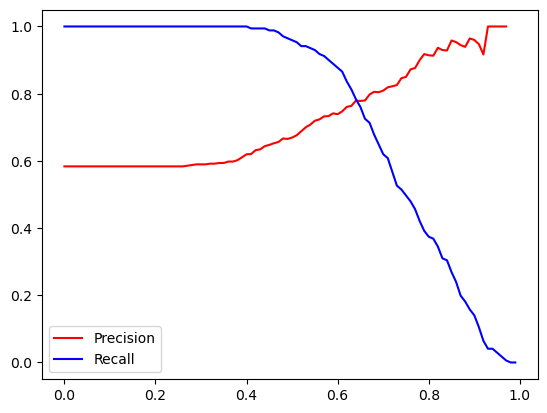

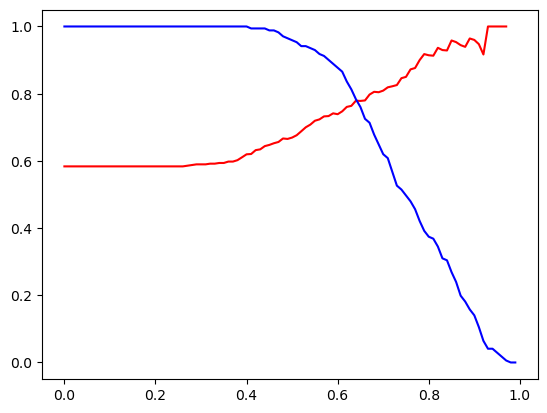

In [23]:
fig, ax = plt.subplots()
ax.plot(thresholds, p_r_df.precision, color='red', label='Precision')
ax.plot(thresholds, p_r_df.recall, color='blue', label='Recall')
plt.show()

In [24]:
p_r_df['minus_abs_p_minus_r'] = p_r_df.p_minus_r.apply(lambda x: -abs(x))
p_r_df[['threshold', 'minus_abs_p_minus_r']].nlargest(5, 'minus_abs_p_minus_r')

,threshold,minus_abs_p_minus_r
64,0.64,-0.004556
65,0.65,-0.018209
63,0.63,-0.049129
66,0.66,-0.054728
62,0.62,-0.075619


### QUESTION 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 ⋅ (P⋅R) / (P+R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [25]:
thresholds = np.linspace(0.0, 0.99, 100)
f1_scores = []
for t in thresholds:
    tp = (y_pred >= t) & (y_val == 1)
    fp = (y_pred >= t) & (y_val == 0)
    tn = (y_pred < t) & (y_val == 0)
    fn = (y_pred < t) & (y_val == 1)
    
    p = tp.sum() / (tp.sum() + fp.sum())
    r = tp.sum() / (tp.sum() + fn.sum())
    f1 = 2*p*r/(p+r)
    f1_scores.append((t, f1))

f1_df = pd.DataFrame(f1_scores, columns=['threshold', 'f-score'])

C:\Users\filip\AppData\Local\Temp\ipykernel_10596\3950889907.py:9: RuntimeWarning: invalid value encountered in scalar divide
  p = tp.sum() / (tp.sum() + fp.sum())


In [26]:
f1_df.nlargest(5, 'f-score')

,threshold,f-score
57,0.57,0.812500
55,0.55,0.811224
56,0.56,0.809278
59,0.59,0.808511
58,0.58,0.808399


### QUESTION 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

- KFold(n_splits=5, shuffle=True, random_state=1)
- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

In [27]:
from sklearn.model_selection import KFold

In [28]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

In [29]:
def predict(X_val, dv, model):
    dicts = X_val.to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

### QUESTION 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.000001, 0.001, 1]
- Initialize KFold with the same parameters as previously
- Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

In [30]:
n_splits = 5

# contains values for C (C=1.0) for questions 5 and 6 (C=[0.01, 0.1, 0.5, 10])
for C in [0.01, 0.1, 0.5, 1, 10]:
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []
    
    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        dv, model = train(X_train, y_train, C)
        y_pred = predict(X_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
    print(f'C: {C:<6} AUC: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')

NameError: name 'X' is not defined